In [1]:
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr


# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Generating the path to the project directory
project_dir = os.path.join(
    pathlib.Path.home(), "earth-analytics", "data", "maple_fire"
)

# Create the project directory
os.makedirs(project_dir, exist_ok=True)

In [3]:
# Define link to fire data
fire_url = (
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/"
    "rest/services/Historic_Geomac_Perimeters_2018/"
    "FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json"
    )

# Create fire_gdf using geopandas
fire_gdf = gpd.read_file(fire_url)

ERROR:fiona._env:URL rejected: No host part in the URL


In [4]:
# Select out the boundary for Maple Fire
maplefire_gdf = fire_gdf.loc[fire_gdf['incidentname'] == 'Maple']

### Pinpoint location of the Maple Fire

The Maple Fire was a wildfire in the Olympic Mountains, Washington. The fire was caused by a crew of timber poachers who were attempting to steal Big-Leaf Maple trees from the Olympic National Park. The crew discovered a potential target tree on August 3, 2018, but were unable to harvest it due to a wasp nest at the base of the tree. After failing to exterminate the nest with insecticides, the crew deliberately set fire to the nest. The fire grew out of control, and the logging crew fled. The fire was reported the following day, and it was not considered contained until October 10, and continued to smolder until seasonal rains finally extinguished it in November. The Maple Fire ultimately burned 3,300 acres (13 km2) of wildland, and was the first time that tree DNA has ever been used in a federal trial in the United States.

In [5]:
# Jefferson Ridge, Washington location
# Found lat/long and updated zoom
paradise_lat = 47.5857
paradise_lon = -123.1370
# Create a Folium map object
m = folium.Map(
    location=[paradise_lat, paradise_lon], 
    zoom_start=13.5,
    scrollWheelZoom=False,
    tiles='Stamen Watercolor')

# Convert the GeoDataFrame to GeoJSON format
maple_geojson = maplefire_gdf.to_json()

# Add the GeoJSON data to the map as a GeoJson layer
maple_style = {
     "fillColor": "red",
        "color": "black",
        "weight": 2,
        "dashArray": "5,5",
}
folium.GeoJson(
    maple_geojson, 
    style_function=lambda feature: maple_style
    ).add_to(m)

# Add a marker 
folium.Marker(location=[paradise_lat, paradise_lon],).add_to(m)


# Display the map
m

In [6]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key="modis-ndvi",
    ea_dir=project_dir,
    product="MYD13Q1.061",
    layer="_250m_16_days_NDVI",
    start_date="08-01",
    end_date="12-31",
    recurring=True,
    year_range=[2017, 2022],
    polygon=maplefire_gdf
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

# AppeearsDownloader

In [7]:
ndvi_path_list = glob(os.path.join(
    ndvi_downloader.data_dir, '*', '*NDVI*.tif'))

In [8]:
doy_start = -19
doy_end = -12
scale_factor = 10000

ndvi_da_list = []
for ndvi_path in ndvi_path_list:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor

    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)


In [9]:
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])

In [10]:
# Calculating mean in 2019
ndvi_mean_2019 = ndvi_ds.sel(date = '2019').mean('date').NDVI

ndvi_mean_2017 = ndvi_ds.sel(date = '2017').mean('date').NDVI


# Calculating difference between 2019-2017
ndvi_diff = ndvi_mean_2019 - ndvi_mean_2017

### Difference in NDVI from before and after the Maple Fire

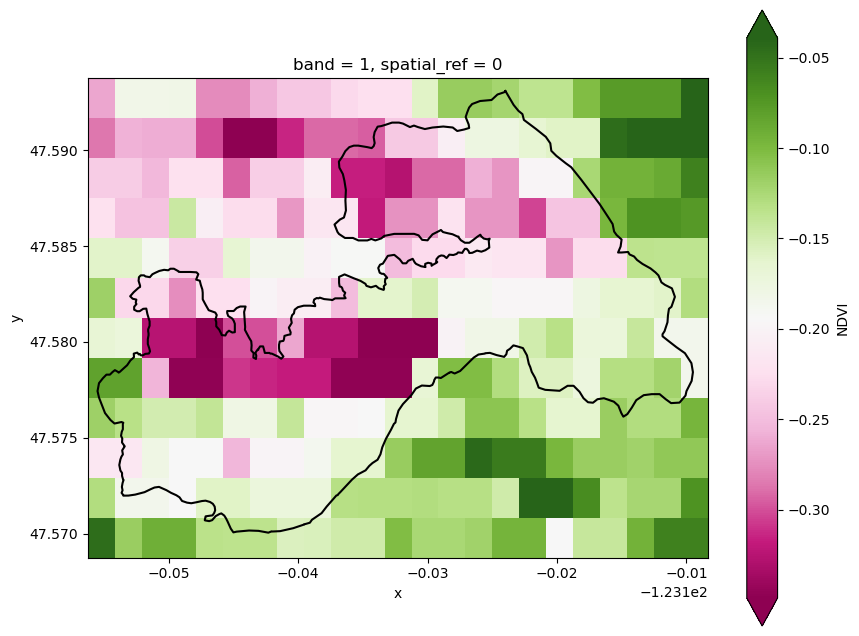

In [11]:
import matplotlib.pyplot as plt

# Plotting with matplot.lib 
fig, ax = plt.subplots(figsize=(10,8))
ndvi_diff.plot(cmap=plt.cm.PiYG,robust=True,ax=ax)
maplefire_gdf.boundary.plot(ax=ax,color='black')
plt.show()

In [12]:
# Get the area outside the fire boundary
out_gdf = (
    gpd.GeoDataFrame(geometry=maplefire_gdf.envelope)
    .overlay(maplefire_gdf, how="difference")
)

In [13]:
ndvi_fire_ds = ndvi_ds.rio.clip(maplefire_gdf.geometry)
ndvi_out_ds = ndvi_ds.rio.clip(out_gdf.geometry)
# Or do it like below
# ndvi_ds.rio.crs, camp_gdf.crs

In [14]:
ndvi_fire_df = (
    ndvi_fire_ds
    .groupby(ndvi_fire_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']])
ndvi_out_df = (
    ndvi_out_ds
    .groupby(ndvi_out_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']])

In [15]:
(ndvi_fire_df - ndvi_out_df).hvplot(
    xlabel='Year', ylabel='dNDVI',
    title='Difference in NDVI between inside and outside Maple fire boundary'
)

:Curve   [year]   (NDVI)

### Vegetation is slowly recovering after Maple Fire!

There was a huge drop in NDVI during the Maple Fire of 2018, specifically from about 0 NDVI to -0.08. However, we can begin to see a slow NDVI recovery after 2021 into 2022, which we can hypothosize will continue in the coming years. NDVI does not tell us the difference between small growth and large forest growth. But, we can assume the large forest growth will take much longer to recover, thus so far what has recovered is smaller growths. 

In [16]:
%%capture
%%bash
jupyter nbconvert ndvi_maple_fire.ipynb --to html --no-input